In [2]:
from exif import Image
from libxmp.utils import file_to_dict
from math import (atan as arctan, degrees, tan, cos)
import sys


In [2]:

with open('kornrows/DJI_20220211072437_0080_Z.JPG', 'rb') as image_file:
    my_image = Image(image_file)

my_image.has_exif

True

In [11]:
for i in my_image.list_all():
    if 'altitude' in i:
        print(i)

gps_altitude_ref
gps_altitude


In [9]:
# probably need:

#my_image.f_number
# digital_zoom_ratio
# focal_length_in_35mm_film
# lens_specification
# focal_length

4.0

In [3]:
xmp = file_to_dict('kornrows/DJI_20220211072437_0080_Z.JPG')

In [4]:
for i in xmp['http://www.dji.com/drone-dji/1.0/']:
    if 'RelativeAltitude' in i[0]:
        rel_alt = float(i[1])
rel_alt

35.386

In [32]:
'''
For example, for 35 mm film which is 36 mm wide and 24 mm high, d=36 mm would be used to obtain the 
horizontal angle of view and d=24 mm for the vertical angle. 
'''


focal_length_35 = 220
focal_length = 47.6


fov = 2 * arctan(35 / focal_length * 2)

afov = 2 / tan(35 / focal_length * 2)

image_w = 2 * (rel_alt / tan(fov / 2))

# scale = focal length m / altitude
scale = (focal_length / 1000) / rel_alt
# scale = sensor pixel size / ground pixel size
# scale = 160
# 160 = 1.45e-6 / ground pixel size


print(f'FoV: {degrees(fov)}°')
print(f'AFoV: {degrees(afov)}°')
print(f'ImageW on ground: {image_w}m')
#degrees(afov)

sensor = [7.6,5.7]

FoV: 111.5685957351252°
AFoV: 11.521592585433607°
ImageW on ground: 48.12496000000001m


In [29]:
w = 5184
h = 3888
of = (1 / 1.7 * 25.4 /1000) # in m
pixel_size = of * 16000 / (w**2 + h**2)**0.5
pixel_size
# 540 px should be 45cm i.e. 0.0009 m/px

0.036891793754538854

In [30]:
gsd = rel_alt * pixel_size / focal_length
gsd

0.02742548348315361

In [47]:
# GSDh= flight height x sensor height / focal length x image height;
gsdh = rel_alt * (sensor[1]) / 47.6 /1000 * h
gsdw = rel_alt * (sensor[0]) / 47.6 /1000 * w
print(gsdw, 'x', gsdh)

29288.90299159664 x 16475.00793277311


In [3]:
from cv2 import imread
from math import atan as arctan
from libxmp.utils import file_to_dict
import find_kornrows as oriente
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import math
import PIL.Image as img
import numpy as np















P2P Lines: 472


AttributeError: module 'sys' has no attribute 'quit'

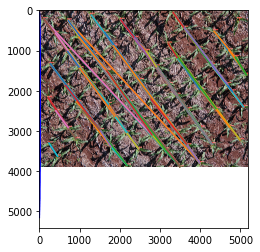

In [9]:
'''
 FOR TODAY, FILTER BY ORIENTATION +-4 FOR ROWS, +- 12 FOR SPACES

'''

#image = imread()
#img_file = 'runs/detect/exp12/DJI_20220211065928_0026_Z.JPG'
#img_file = 'kornrows/DJI_20220211065254_0005_Z.JPG'
img_file = 'kornrows/DJI_20220211071229_0062_Z.JPG'
lbls = img_file[:-3] + 'txt'
rgb = img.open(img_file)
dims = rgb.size

orientation = 180-37
plants = []
with open(lbls, 'r') as lbls_txt:
    for line in lbls_txt:
        obj_class, x, y, w, h = line.split(' ')
        plants.append([float(x) * dims[0], float(y) * dims[1]])

points = [Point(plant) for plant in plants]

plt.imshow(rgb)

for plant in points:
    plt.plot(plant, color='blue')
    #plt.plot(line[1].xy[0], line[1].xy[1], color='yellow') # Equivalent

plt.savefig(f'kornrows/output_AG_plants.png', dpi=300)
print('\n\n\n\n\n\n\n\n\n\n\n\n\n')

def azimuth(point1, point2):
    '''azimuth between 2 shapely points (interval 0 - 180°, for my work)'''
    angle = math.atan2(point1, point2)
    return math.degrees(angle) if angle > 0 else math.degrees(angle) + 180



def get_p2p_lines(points, orientation, threshold):
    # get all point to point lines
    all_lines = []
    line_id = 0
    for point0 in points:
        for point1 in points:
            dx = point1.x - point0.x
            dy = point1.y - point0.y
            #print(f'dx: {dx}, dy: {dy}')
            if dx * dy != 0:
                bearing = azimuth(dx, dy)
                if abs(bearing - (180 - orientation)) < threshold or abs(bearing - (180 + orientation)) < threshold:
                    all_lines.append((line_id, LineString([point0, point1])))
                    line_id += 1
                    #print(bearing)
    return all_lines


all_lines = get_p2p_lines(points, orientation, 6)
print(f'P2P Lines: {len(all_lines)}') 
for i in [line[0] for line in all_lines]:
    plt.plot(i)
#print()

def find_rows(lines):
    intersections = 0
    long_lines = []
    long_lines_ids = []
    for line0 in lines:
        crosses = 0
        for line1 in lines:
            if line0[1].touches(line1[1]):
                intersections += 1
                crosses += 1
                if line0[1].length > line1[1].length and line0[0] not in long_lines_ids:
                    long_lines.append(line0)
                    long_lines_ids.append(line0[0])

        if crosses == 0:
            long_lines.append(line0)
            long_lines_ids.append(line0[0])            
    if intersections == 0:
        long_lines = lines        
    print(f'{intersections} intersections\t{len(long_lines)} lines')
    return intersections, long_lines

#intersections, rows = find_rows(all_lines)
#while intersections > 0:
#    intersections, rows = find_rows(rows)
#uniqlines = []
#for id, line in rows:
#    if not any(p[1].equals(line) for p in uniqlines):
#        uniqlines.append((id, line))
#print(f'Unique corn rows: {len(uniqlines)}')

buff_cornrows = [line[1].buffer(100) for line in uniqlines]

plt.imshow(rgb)

#ax.plot(line.xy[0], line.xy[1])
#for poly in buff_cornrows:
#    plt.plot(*poly.exterior.xy, color='yellow', alpha=0.85)
#    #plt.plot(line[1].xy[0], line[1].xy[1], color='yellow') # Equivalent

for line in all_lines:
    plt.plot(line[1].xy[0], line[1].xy[1])
    #plt.plot(line[1].xy[0], line[1].xy[1], color='yellow') # Equivalent

plt.savefig(f'kornrows/output_AG_rows.png', dpi=300)

def find_single_lines(lines, row_buffers):
    intersections = 0
    short_lines_ids = []
    short_lines = []
    for line0 in lines:
        crosses = 0
        for line1 in lines:
            if line0[1].crosses(line1[1]):
                intersections += 1
                crosses += 1
                if line0[1].length < line1[1].length and line0[0] not in short_lines_ids:
                    intersected_rows = [row for row in row_buffers if line0[1].intersects(row)]
                    if len(intersected_rows) <= 1:
                        short_lines.append(line0)
                        short_lines_ids.append(line0[0])

        if crosses == 0:
            short_lines.append(line0)
            short_lines_ids.append(line0[0])            
    if intersections == 0:
        short_lines = lines        
    print(f'{intersections} intersections\t{len(short_lines)} lines')
    return intersections, short_lines

all_lines = get_p2p_lines(points, orientation, 5)
intersections, short_lines = find_single_lines(all_lines, buff_cornrows)
while intersections > 0:
    intersections, short_lines = find_single_lines(short_lines, buff_cornrows)

# filter
slines = []
for id, line in short_lines:
    line_area = line.buffer(100)
    contained_plants = [plant for plant in points if line_area.contains(plant)]
    if len(contained_plants) < 3:
        slines.append((id, line))
print(f'Unique corn plant spaces: {len(slines)}')

print(len(slines))
short_lines = slines

distances = [line[1].length for line in short_lines]
cov = np.std(distances) / np.mean(distances) * 100
print(f'CV: {cov}')

for line in short_lines:
    plt.plot(line[1].xy[0], line[1].xy[1]) # Equivalent

plt.savefig(f'kornrows/outputAG_spaces.png', dpi=300)



In [62]:
line1 = LineString([(0, 0), (1, 1)])
line2 = LineString([(0, 0), (0, 1)])
line1.touches(line2)

True

128
1800 intersections	108 lines
1256 intersections	92 lines
952 intersections	78 lines
712 intersections	64 lines
448 intersections	48 lines
232 intersections	32 lines
104 intersections	20 lines
24 intersections	14 lines
0 intersections	14 lines
14
Unique corn rows: 7


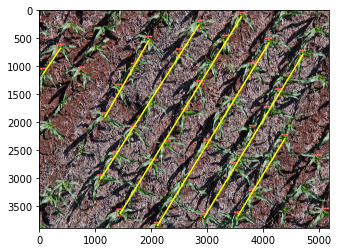

In [21]:
'''
 GO FOR FINDING ALL FULL KORN ROWS

'''

#image = imread()
img_file = 'runs/detect/exp12/DJI_20220211065928_0026_Z.JPG'
lbls = img_file[:-3] + 'txt'
rgb = img.open(img_file)
dims = rgb.size

orientation = 31.0
plants = []
with open(lbls, 'r') as lbls_txt:
    for line in lbls_txt:
        obj_class, x, y, w, h = line.split(' ')
        plants.append([float(x) * dims[0], float(y) * dims[1]])

def azimuth(point1, point2):
    '''azimuth between 2 shapely points (interval 0 - 180°, for my work)'''
    angle = math.atan2(point1, point2)
    return math.degrees(angle)if angle>0 else math.degrees(angle) + 180

# get all point to point lines
points0 = [Point(plant) for plant in plants]
points1 = [Point(plant) for plant in plants]
#print(f'Nr points: {len(points0)}')
all_lines = []
line_id = 0
for point0 in points0:
    for point1 in points1:
        dx = point1.x - point0.x
        dy = point1.y - point0.y
        #print(f'dx: {dx}, dy: {dy}')
        if dx * dy != 0:
            bearing = azimuth(dx, dy)
            if abs(bearing - (180 - orientation)) < 6:
                all_lines.append((line_id, LineString([point0, point1])))
                line_id += 1
                #print(bearing)

print(len(all_lines))

def filter_lines(lines):
    intersections = 0
    long_lines = []
    long_lines_ids = []
    for line0 in lines:
        crosses = 0
        for line1 in lines:
            if line0[1].touches(line1[1]):
                intersections += 1
                crosses += 1
                if line0[1].length > line1[1].length and line0[0] not in long_lines_ids:
                    long_lines.append(line0)
                    long_lines_ids.append(line0[0])

        if crosses == 0:
            long_lines.append(line0)
            long_lines_ids.append(line0[0])            
    if intersections == 0:
        long_lines = lines        
    print(f'{intersections} intersections\t{len(long_lines)} lines')
    return intersections, long_lines

intersections, short_lines = filter_lines(all_lines)
while intersections > 0:
    intersections, short_lines = filter_lines(short_lines)

print(len(short_lines))

uniqlines = []
for id, line in short_lines:

    if not any(p[1].equals(line) for p in uniqlines):
        uniqlines.append((id, line))
print(f'Unique corn rows: {len(uniqlines)}')

plt.imshow(rgb)

#ax.plot(line.xy[0], line.xy[1])
for line in uniqlines:
    plt.plot(line[1].xy[0], line[1].xy[1], color='yellow') # Equivalent

#plt.plot(all_lines)

#plt.show()
plt.savefig(f'kornrows/output_long.png', dpi=300)


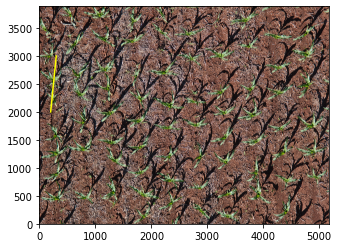

In [6]:
img_file = 'kornrows/DJI_20220211065254_0005_Z.JPG'
lbls = img_file[:-3] + 'txt'
rgb = img.open(img_file)
rgb = rgb.transpose(img.FLIP_TOP_BOTTOM)
plt.imshow(rgb, origin='lower')
plt.plot([200,300], [2000,3000], color='yellow')

In [1]:
import pandas as pd

data = pd.read_json('kornrows/200/done/output.json')
data.to_csv('kornrows/200/done/output0.csv')